In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['incedodataclean', 'incedonlpdata']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,Bidirectional,BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import  to_categorical
%matplotlib inline

Using TensorFlow backend.


In [3]:
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
import re
import nltk

In [4]:
stopwords = nltk.corpus.stopwords.words('english')

In [5]:
def clean_text(text):
    
    text=re.sub(r"[^a-zA-Z]"," ",text)
    text=text.lower()
    #text=re.sub(r"[0-9]","",text)
    text=re.sub(r"i'm","i am",text)
    text=re.sub(r"he's","he is",text)
    text=re.sub(r"she's","she is",text)
    text=re.sub(r"that's","that is",text)
    text=re.sub(r"what's","what is",text)
    text=re.sub(r"where's","where is",text)
    text=re.sub(r"\'ll"," will",text)
    text=re.sub(r"\'ve"," have",text)
    text=re.sub(r"\'re"," are",text)
    text=re.sub(r"\'d"," would",text)
    text=re.sub(r"won't","will not",text)
    text=re.sub(r"can't","cannot",text)
    text=re.sub(r"[-()\"#/@;:<>{}+=~|.?,]","",text)
    word_tokens = word_tokenize(text)
    filtered_sentence = [lemmatizer.lemmatize(w) for w in word_tokens if w not in stopwords]
    text=" ".join(filtered_sentence)
    return text

In [6]:
train=pd.read_csv('../input/incedodataclean/clean_text_apr26.csv')

In [7]:
train.head()

,ID,Essayset,min_score,max_score,score_1,score_2,score_3,score_4,score_5,clarity,coherent,EssayText
0,1,1.0,0,3,1,1,1.0,1.0,1.0,average,worst,additional information would need replicate ex...
1,3,1.0,0,3,1,1,1.0,1.0,1.5,worst,above_average,need trial control set exact amount vinegar po...
2,4,1.0,0,3,0,0,0.0,0.0,1.0,worst,worst,student list rock better rock worse procedure
3,5,1.0,0,3,2,2,2.0,2.5,1.0,above_average,worst,student able make replicate would need tell us...
4,6,1.0,0,3,1,0,0.0,0.0,0.0,worst,worst,would need information would let different sam...


In [8]:
train['avg_score']=np.round((train.score_1+train.score_2+train.score_3)/3)

In [9]:
train.drop(columns=['score_1','score_2','score_3','score_4','score_5'],inplace=True)

In [10]:
train.head()

,ID,Essayset,min_score,max_score,clarity,coherent,EssayText,avg_score
0,1,1.0,0,3,average,worst,additional information would need replicate ex...,1.0
1,3,1.0,0,3,worst,above_average,need trial control set exact amount vinegar po...,1.0
2,4,1.0,0,3,worst,worst,student list rock better rock worse procedure,0.0
3,5,1.0,0,3,above_average,worst,student able make replicate would need tell us...,2.0
4,6,1.0,0,3,worst,worst,would need information would let different sam...,0.0


In [11]:
train2=train.drop(columns=['ID','Essayset','min_score','max_score','clarity','coherent'])

In [12]:
train2.head()

,EssayText,avg_score
0,additional information would need replicate ex...,1.0
1,need trial control set exact amount vinegar po...,1.0
2,student list rock better rock worse procedure,0.0
3,student able make replicate would need tell us...,2.0
4,would need information would let different sam...,0.0


In [13]:
max_words = 2500
max_len = 50
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(train2.EssayText)
sequences = tok.texts_to_sequences(train2.EssayText)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
Y1=train2.avg_score

In [14]:
X_train,X_test,Y_train,Y_test = train_test_split(sequences_matrix,to_categorical(Y1),test_size=0.20)


In [15]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(64))(layer)
    #layer = Bidirectional(LSTM(128))(layer)
    layer = Dense(64,name='FC1')(layer)
    #layer=BatchNormalization()(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(64,name='FC2')(layer)
    #layer=BatchNormalization()(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(4,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [16]:
model = RNN()
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.fit(X_train,Y_train,batch_size=64,epochs=2,validation_data=(X_test,Y_test))

Train on 12937 samples, validate on 3235 samples
Epoch 1/2
12937/12937 [==============================] - 60s 5ms/step - loss: 0.9979 - acc: 0.5625 - val_loss: 0.8330 - val_acc: 0.6371
Epoch 2/2
12937/12937 [==============================] - 53s 4ms/step - loss: 0.8013 - acc: 0.6645 - val_loss: 0.7876 - val_acc: 0.6504


In [17]:
y_pred_train=model.predict(sequences_matrix)

In [18]:
tt1=pd.DataFrame(y_pred_train,columns=['out1','out2','out3','out4'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd30a9869b0>,
      dtype=object)

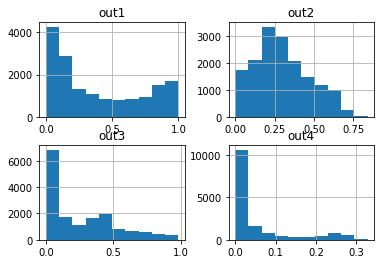

In [19]:
tt1.hist()

In [20]:
train3=train.drop(columns=['ID','min_score','max_score','EssayText'])

In [21]:
train4=pd.concat([train3,tt1],axis=1)

In [22]:
train4.head()

,Essayset,clarity,coherent,avg_score,out1,out2,out3,out4
0,1.0,average,worst,1.0,0.104490,0.243030,0.426676,0.225804
1,1.0,worst,above_average,1.0,0.529580,0.350655,0.095218,0.024548
2,1.0,worst,worst,0.0,0.854163,0.136912,0.008358,0.000567
3,1.0,above_average,worst,2.0,0.124353,0.255107,0.397761,0.222779
4,1.0,worst,worst,0.0,0.656849,0.270378,0.059755,0.013017


In [23]:
import category_encoders as ce

In [24]:
ce1=ce.TargetEncoder(cols = ['Essayset','clarity','coherent'], min_samples_leaf = 20)

In [25]:
train4.loc[:,['Essayset','clarity','coherent']]=ce1.fit_transform(train4.loc[:,['Essayset','clarity','coherent']],train4.loc[:,['avg_score']])

In [26]:
train4.head()

,Essayset,clarity,coherent,avg_score,out1,out2,out3,out4
0,1.480649,0.496662,0.482423,1.0,0.104490,0.243030,0.426676,0.225804
1,1.480649,0.486640,1.944411,1.0,0.529580,0.350655,0.095218,0.024548
2,1.480649,0.486640,0.482423,0.0,0.854163,0.136912,0.008358,0.000567
3,1.480649,1.943451,0.482423,2.0,0.124353,0.255107,0.397761,0.222779
4,1.480649,0.486640,0.482423,0.0,0.656849,0.270378,0.059755,0.013017


In [27]:
X1=train4.drop(columns=['avg_score'])
Y1=train4.avg_score

In [28]:
from xgboost import XGBClassifier
xgb=XGBClassifier(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.01,
                 max_depth=4,
              
                 min_child_weight=0.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [29]:
X1_train,X1_test,Y1_train,Y1_test=train_test_split(X1,Y1,test_size=0.2,random_state=123)

In [30]:
xgb.fit(X1_train,Y1_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=0.5, missing=None, n_estimators=10000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.6, verbosity=1)

In [31]:
yy_test=xgb.predict(X1_test)

In [32]:
from sklearn.metrics import  accuracy_score,classification_report

In [33]:
accuracy_score(Y1_test,yy_test)

0.7938176197836166

In [34]:
print(classification_report(Y1_test,yy_test))

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      1309
         1.0       0.75      0.73      0.74      1053
         2.0       0.81      0.81      0.81       749
         3.0       0.49      0.46      0.47       124

    accuracy                           0.79      3235
   macro avg       0.72      0.72      0.72      3235
weighted avg       0.79      0.79      0.79      3235



In [35]:
test=pd.read_csv('../input/incedonlpdata/incedo_nlpcadad7d/incedo_participant/test_dataset.csv')

In [36]:
test2=test.drop(columns=['ID','min_score','max_score'])

In [37]:
test2.head()

,Essayset,clarity,coherent,EssayText
0,1,average,worst,The procedures I think they should have includ...
1,1,average,worst,"In order to replicate this experiment, you wou..."
2,1,above_average,above_average,"In order to replicate their experiment, you wo..."
3,1,worst,worst,Pleace a simple of one material into one conta...
4,1,worst,worst,Determin the mass of four different samples ma...


In [38]:
test2['EssayText']=test2['EssayText'].apply(clean_text)

In [39]:
sequences_test = tok.texts_to_sequences(test2.EssayText)
sequences_matrix_test = sequence.pad_sequences(sequences_test,maxlen=max_len)


In [40]:
test2_test=model.predict(sequences_matrix_test)

In [41]:
testdf=pd.DataFrame(test2_test,columns=['out1','out2','out3','out4'])

In [42]:
test3=pd.concat([test2,testdf],axis=1)

In [43]:
test3.drop(columns=['EssayText'],inplace=True)

In [44]:
test3.head()

,Essayset,clarity,coherent,out1,out2,out3,out4
0,1,average,worst,0.693615,0.251838,0.046390,0.008156
1,1,average,worst,0.119727,0.241365,0.392492,0.246416
2,1,above_average,above_average,0.152764,0.261027,0.350190,0.236019
3,1,worst,worst,0.373783,0.367466,0.184230,0.074521
4,1,worst,worst,0.979062,0.020739,0.000197,0.000002


In [45]:
test3.loc[:,['Essayset','clarity','coherent']]=ce1.transform(test3.loc[:,['Essayset','clarity','coherent']])

In [46]:
test3.head()

,Essayset,clarity,coherent,out1,out2,out3,out4
0,1.480649,0.496662,0.482423,0.693615,0.251838,0.046390,0.008156
1,1.480649,0.496662,0.482423,0.119727,0.241365,0.392492,0.246416
2,1.480649,1.943451,1.944411,0.152764,0.261027,0.350190,0.236019
3,1.480649,0.486640,0.482423,0.373783,0.367466,0.184230,0.074521
4,1.480649,0.486640,0.482423,0.979062,0.020739,0.000197,0.000002


In [47]:
final_out=xgb.predict(test3)

In [48]:
out=pd.DataFrame()

In [49]:
out['id']=test.ID
out['essay_set']=test.Essayset


In [50]:
out['essay_score']=final_out
out.tail()

,id,essay_set,essay_score
5219,28130,10,1.0
5220,28131,10,2.0
5221,28132,10,1.0
5222,28133,10,1.0
5223,28134,10,1.0


In [51]:
out.to_csv('incedo_nlp28aprv1.csv',index=None)

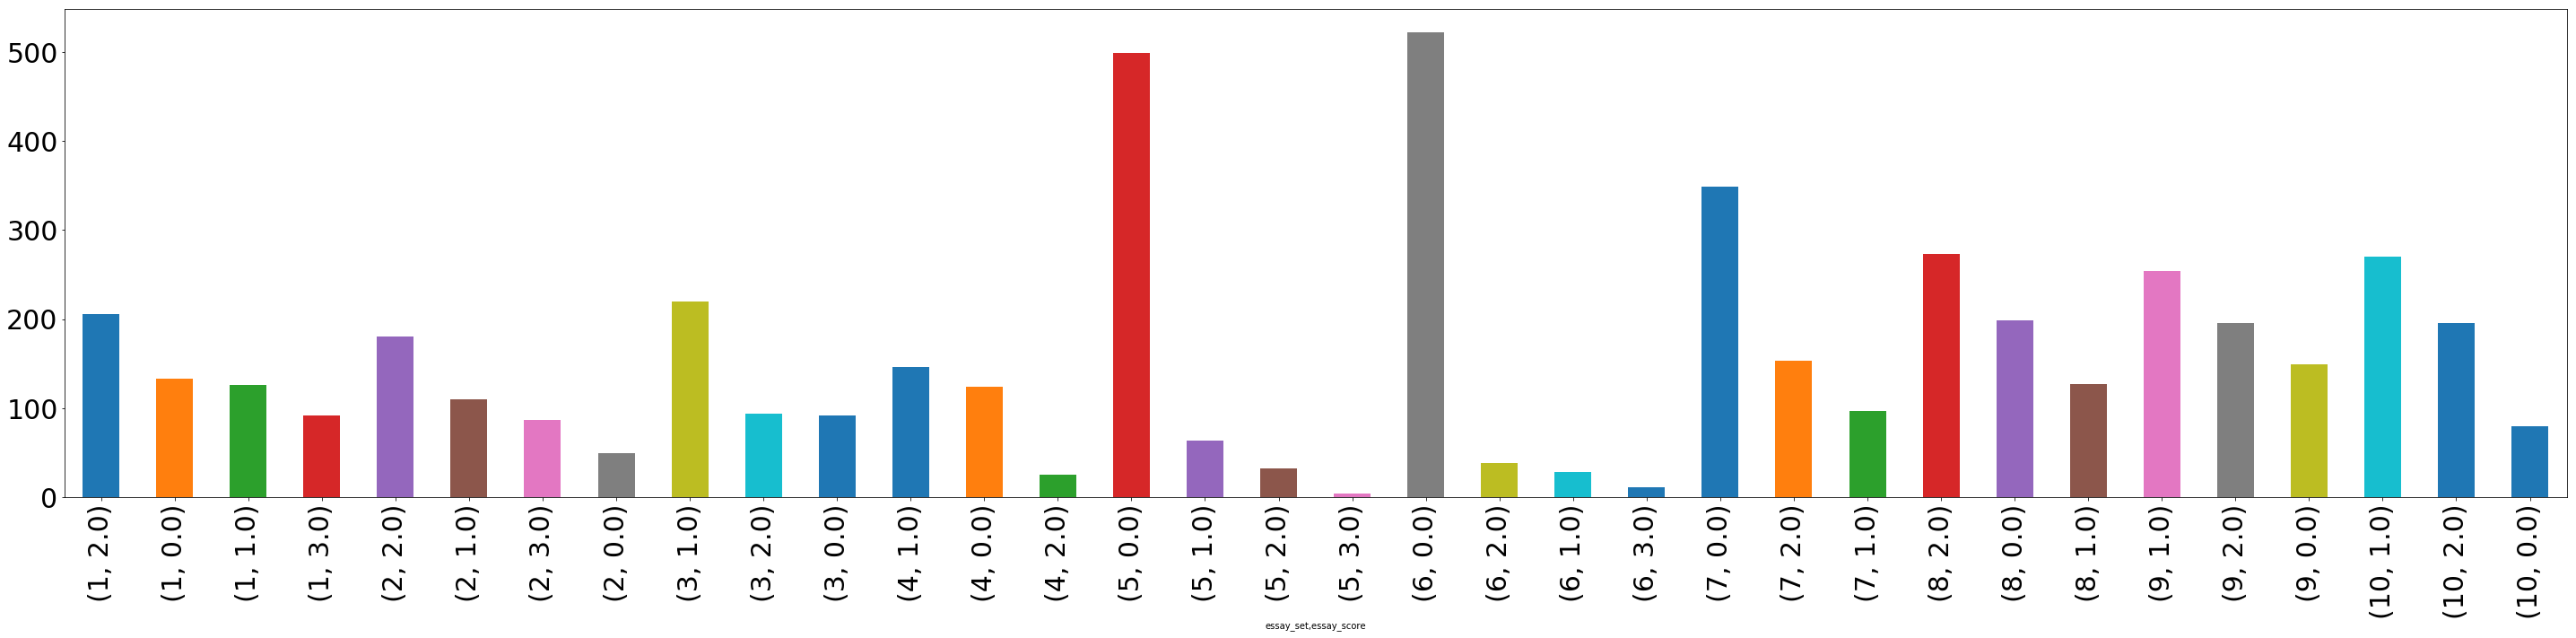

In [52]:
out.groupby('essay_set').essay_score.value_counts().plot(kind='bar',figsize=(50,10),fontsize=30)